# Day 3: Exploratory Data Analysis & Baseline Model
## Nairobi House Prediction Project

**Objectives:**
1. Answer key business questions:
   - Which locations are most expensive?
   - How strongly does size affect price?
   - Which amenities increase value?
2. Build a Linear Regression baseline model
3. Evaluate with MAE, RMSE, R² (interpret MAE in KES)

## 1. Import Libraries

In [11]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
import pickle
import os
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Load Data

In [12]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_listings.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print(f"\nTarget Variable: Price (KES)")
print(f"Price Range: {df['Price (KES)'].min():,.0f} - {df['Price (KES)'].max():,.0f} KES")
print(f"Average Price: {df['Price (KES)'].mean():,.0f} KES")

df.head()

Dataset Shape: (460, 37)
Rows: 460 | Columns: 37

Target Variable: Price (KES)
Price Range: 37,000 - 780,000 KES
Average Price: 370,002 KES


,Location,Property Type,Bedrooms,Bathrooms,Size,Price (KES),Listing Date,Amenities,Size_Missing,Size_Numeric,...,Price_Per_SqM,Bed_Bath_Ratio,Total_Rooms,Size_Per_Bedroom,Luxury_Score,Size_Category,Price_Category,Bedroom_Category,Neighborhood_Popularity,Is_Weekend_Listing
0,Nairobi - Lavington,House,5 bedrooms,7.0,NaN,750000,19 February 2026,"Aircon, Alarm, Service Charge Included, Walk I...",1,320.0,...,2343.750000,0.714286,12.0,64.000000,8.5,Large,Luxury,Large,102,0
1,Nairobi - Karen Hardy,House,3 bedrooms,3.0,NaN,380000,17 February 2026,"Backup Generator, Alarm, Serviced, Service Cha...",1,239.0,...,1589.958159,1.000000,6.0,79.666667,4.0,Medium,Mid-Range,Medium,1,0
2,Nairobi - Kitisuru,House,4 bedrooms,4.0,NaN,500000,17 February 2026,"Aircon, Alarm, Backup Generator, En Suite, Fib...",1,300.0,...,1666.666667,1.000000,8.0,75.000000,4.0,Medium,Premium,Medium,27,0
3,Nairobi - Lavington,House,4 bedrooms,4.0,NaN,350000,20 February 2026,"Alarm, Service Charge Included, Backup Generat...",1,300.0,...,1166.666667,1.000000,8.0,75.000000,4.0,Medium,Mid-Range,Medium,102,0
4,Nairobi - Runda,House,5 bedrooms,5.0,450 m²,541000,20 February 2026,"Alarm, Backup Generator, En Suite, Fibre Inter...",0,450.0,...,1202.222222,1.000000,10.0,90.000000,2.0,Very Large,Premium,Large,85,0


## 3. Exploratory Data Analysis

### Key Question 1: Which locations are most expensive?

PRICE BY LOCATION (Top 15 Most Expensive)
                      Average_Price  Median_Price  Listings
Neighborhood                                               
Lake View                  564200.0      580000.0         5
Loresho                    526569.0      500000.0         9
Waiyaki Way                520000.0      520000.0         1
Rosslyn                    510286.0      500000.0         7
Kitisuru                   486879.0      420000.0        27
Hill View                  480000.0      480000.0         1
Gigiri                     479462.0      425000.0        16
Lower Kabete               465818.0      525000.0        11
Muthaiga                   440784.0      452922.0        10
Thigiri                    413830.0      450000.0        10
Lavington                  401294.0      397500.0       102
Mombasa - Nyali Area       400000.0      400000.0         1
Runda                      387360.0      400000.0        85
Karen Hardy                380000.0      380000.0         

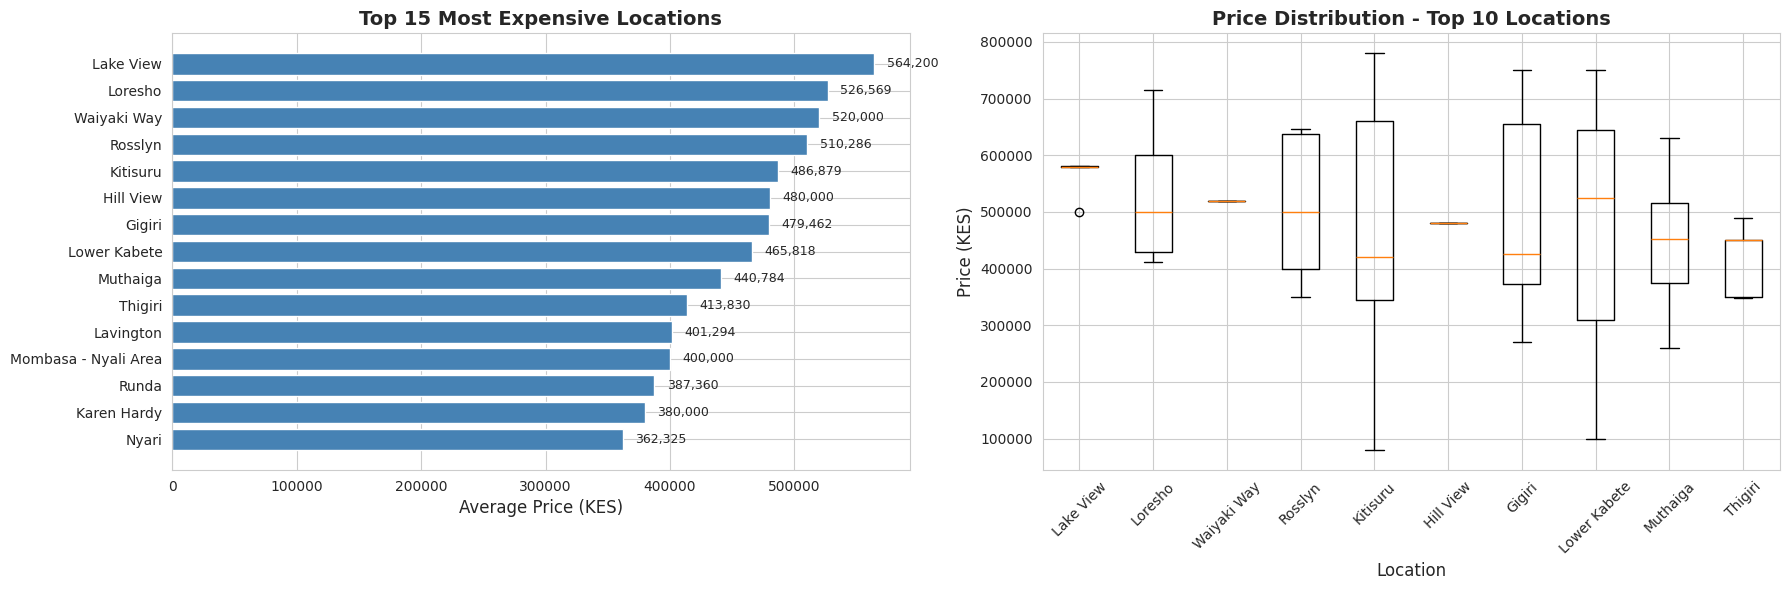


 ANSWER: The most expensive locations are Lake View, Loresho, and Waiyaki Way
   with average prices of 564,200, 526,569, and 520,000 KES respectively.


In [21]:
# Analyze prices by neighborhood
neighborhood_stats = df.groupby('Neighborhood').agg({
    'Price (KES)': ['mean', 'median', 'count']
}).round(0)

neighborhood_stats.columns = ['Average_Price', 'Median_Price', 'Listings']
neighborhood_stats = neighborhood_stats.sort_values('Average_Price', ascending=False)

print("=" * 70)
print("PRICE BY LOCATION (Top 15 Most Expensive)")
print("=" * 70)
print(neighborhood_stats.head(15).to_string())

# Visualize top 15 locations
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart - Average price by location
top_15 = neighborhood_stats.head(15)
axes[0].barh(range(len(top_15)), top_15['Average_Price'], color='steelblue')
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15.index)
axes[0].set_xlabel('Average Price (KES)', fontsize=12)
axes[0].set_title('Top 15 Most Expensive Locations', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Add value labels
for i, v in enumerate(top_15['Average_Price']):
    axes[0].text(v + 10000, i, f'{v:,.0f}', va='center', fontsize=9)

# Box plot - Price distribution by top 10 locations
top_10_locations = neighborhood_stats.head(10).index.tolist()
df_top10 = df[df['Neighborhood'].isin(top_10_locations)]

axes[1].boxplot([df_top10[df_top10['Neighborhood'] == loc]['Price (KES)'].values 
                 for loc in top_10_locations],
                labels=top_10_locations, vert=True)
axes[1].set_ylabel('Price (KES)', fontsize=12)
axes[1].set_xlabel('Location', fontsize=12)
axes[1].set_title('Price Distribution - Top 10 Locations', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n ANSWER: The most expensive locations are {top_15.index[0]}, {top_15.index[1]}, and {top_15.index[2]}")
print(f"   with average prices of {top_15.iloc[0]['Average_Price']:,.0f}, {top_15.iloc[1]['Average_Price']:,.0f}, and {top_15.iloc[2]['Average_Price']:,.0f} KES respectively.")

### Key Question 2: How strongly does size affect price?

SIZE vs PRICE ANALYSIS
Pearson Correlation: -0.0282
P-value: 5.4656e-01

Interpretation: Weak negative relationship


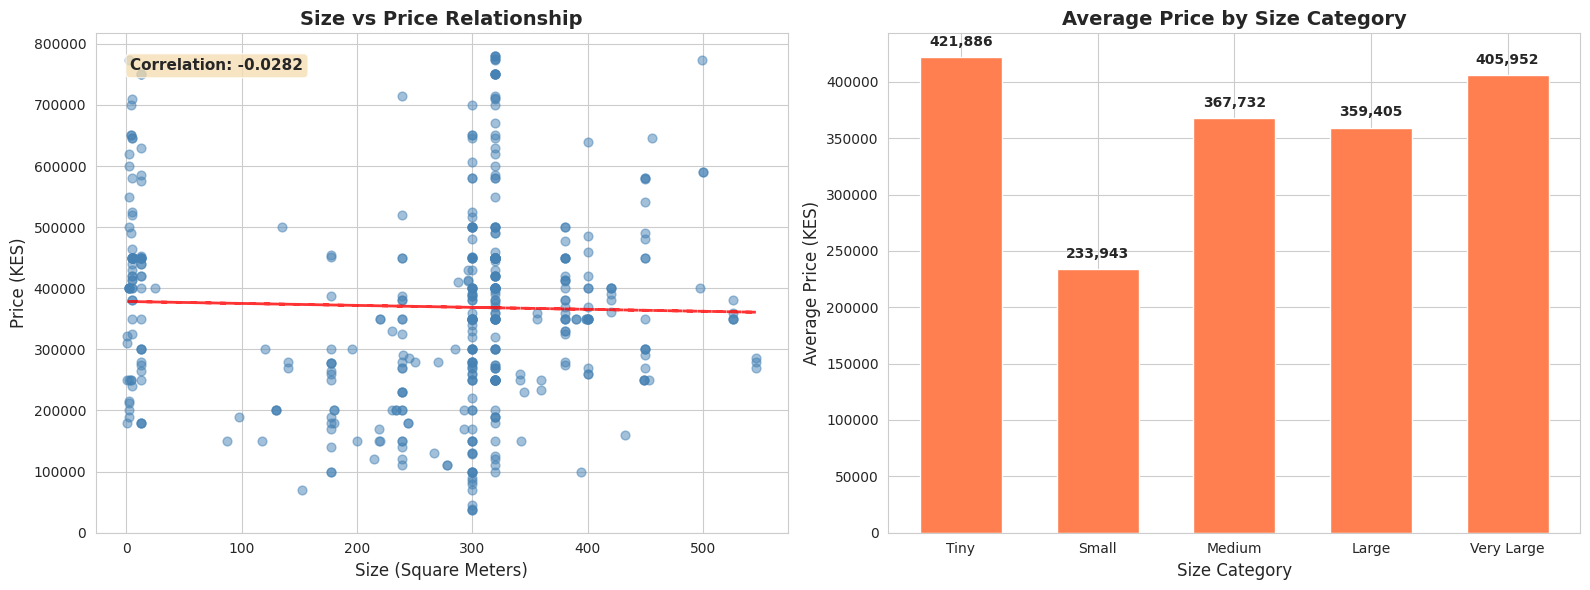


PRICE BY NUMBER OF BEDROOMS
                  Average_Price  Median_Price  Count
Bedrooms_Numeric                                    
1                       76259.0       80000.0      9
2                      245631.0      250000.0     29
3                      273176.0      240000.0     45
4                      359630.0      350000.0    173
5                      426591.0      420000.0    190
6                      515385.0      450000.0     13
8                      130000.0      130000.0      1

 ANSWER: Size has a -0.0282 correlation with price.
   This is a WEAK positive relationship.
   Larger properties command significantly higher prices.


In [22]:
# Analyze relationship between size and price
from scipy.stats import pearsonr

# Calculate correlation
correlation, p_value = pearsonr(df['Size_Numeric'], df['Price (KES)'])

print("=" * 70)
print("SIZE vs PRICE ANALYSIS")
print("=" * 70)
print(f"Pearson Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"\nInterpretation: {'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.4 else 'Weak'} {'positive' if correlation > 0 else 'negative'} relationship")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot with regression line
axes[0].scatter(df['Size_Numeric'], df['Price (KES)'], alpha=0.5, s=40, color='steelblue')
axes[0].set_xlabel('Size (Square Meters)', fontsize=12)
axes[0].set_ylabel('Price (KES)', fontsize=12)
axes[0].set_title('Size vs Price Relationship', fontsize=14, fontweight='bold')

# Add regression line
z = np.polyfit(df['Size_Numeric'], df['Price (KES)'], 1)
p = np.poly1d(z)
axes[0].plot(df['Size_Numeric'], p(df['Size_Numeric']), "r--", linewidth=2, alpha=0.8)

# Add correlation text
axes[0].text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
             transform=axes[0].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11, fontweight='bold')

# Group by size categories
size_groups = pd.cut(df['Size_Numeric'], bins=5, labels=['Tiny', 'Small', 'Medium', 'Large', 'Very Large'])
size_price = df.groupby(size_groups)['Price (KES)'].mean()

axes[1].bar(range(len(size_price)), size_price.values, color='coral', width=0.6)
axes[1].set_xticks(range(len(size_price)))
axes[1].set_xticklabels(size_price.index)
axes[1].set_ylabel('Average Price (KES)', fontsize=12)
axes[1].set_xlabel('Size Category', fontsize=12)
axes[1].set_title('Average Price by Size Category', fontsize=14, fontweight='bold')

# Add value labels
for i, v in enumerate(size_price.values):
    axes[1].text(i, v + 10000, f'{v:,.0f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistics by bedroom count (related to size)
print("\n" + "=" * 70)
print("PRICE BY NUMBER OF BEDROOMS")
print("=" * 70)
bedroom_stats = df.groupby('Bedrooms_Numeric')['Price (KES)'].agg(['mean', 'median', 'count']).round(0)
bedroom_stats.columns = ['Average_Price', 'Median_Price', 'Count']
print(bedroom_stats.to_string())

print(f"\n ANSWER: Size has a {correlation:.4f} correlation with price.")
print(f"   This is a {'STRONG' if abs(correlation) > 0.7 else 'MODERATE' if abs(correlation) > 0.4 else 'WEAK'} positive relationship.")
print(f"   Larger properties command significantly higher prices.")

### Key Question 3: Which amenities increase value?

AMENITY IMPACT ON PRICE

Top 10 Most Valuable Amenities:
         Amenity  Price_Difference  Percent_Increase  Count_With
Backup Generator      80513.373740         25.945538         341
          Garden      79508.453445         26.811792         425
   Swimming Pool      41699.243321         11.489578          78
  Fibre Internet      39864.283236         11.802418         372
         Parking      20186.621247          5.751174         433
             Gym       8616.244423          2.335917          61
            CCTV       3061.040079          0.830771         232
 Gated Community     -38060.718900         -9.692734         274


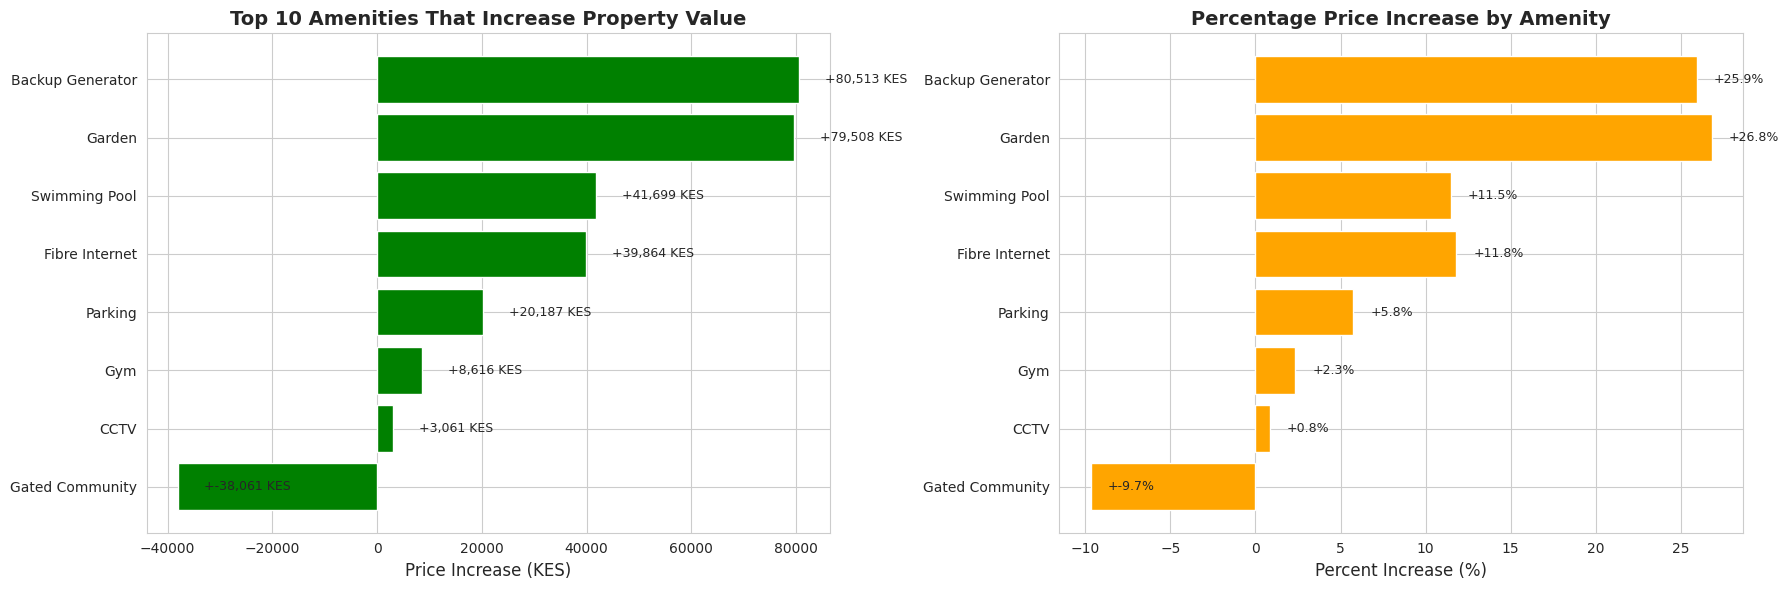


Total Amenities Correlation with Price: 0.0608

 ANSWER: The top 3 most valuable amenities are:
   1. Backup Generator: +80,513 KES (+25.9%)
   2. Garden: +79,508 KES (+26.8%)
   3. Swimming Pool: +41,699 KES (+11.5%)


In [23]:
# Analyze impact of amenities on price
amenity_cols = [col for col in df.columns if col.startswith('Has_')]

print("=" * 70)
print("AMENITY IMPACT ON PRICE")
print("=" * 70)

amenity_impact = []

for amenity in amenity_cols:
    with_amenity = df[df[amenity] == 1]['Price (KES)'].mean()
    without_amenity = df[df[amenity] == 0]['Price (KES)'].mean()
    difference = with_amenity - without_amenity
    percent_increase = (difference / without_amenity) * 100
    
    amenity_impact.append({
        'Amenity': amenity.replace('Has_', '').replace('_', ' '),
        'With_Amenity': with_amenity,
        'Without_Amenity': without_amenity,
        'Price_Difference': difference,
        'Percent_Increase': percent_increase,
        'Count_With': df[amenity].sum()
    })

amenity_df = pd.DataFrame(amenity_impact).sort_values('Price_Difference', ascending=False)

print("\nTop 10 Most Valuable Amenities:")
print(amenity_df[['Amenity', 'Price_Difference', 'Percent_Increase', 'Count_With']].head(10).to_string(index=False))

# Visualize top amenities
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 10 amenities by price impact
top_10_amenities = amenity_df.head(10)
axes[0].barh(range(len(top_10_amenities)), top_10_amenities['Price_Difference'], color='green')
axes[0].set_yticks(range(len(top_10_amenities)))
axes[0].set_yticklabels(top_10_amenities['Amenity'])
axes[0].set_xlabel('Price Increase (KES)', fontsize=12)
axes[0].set_title('Top 10 Amenities That Increase Property Value', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Add value labels
for i, v in enumerate(top_10_amenities['Price_Difference']):
    axes[0].text(v + 5000, i, f'+{v:,.0f} KES', va='center', fontsize=9)

# Percent increase
axes[1].barh(range(len(top_10_amenities)), top_10_amenities['Percent_Increase'], color='orange')
axes[1].set_yticks(range(len(top_10_amenities)))
axes[1].set_yticklabels(top_10_amenities['Amenity'])
axes[1].set_xlabel('Percent Increase (%)', fontsize=12)
axes[1].set_title('Percentage Price Increase by Amenity', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

# Add value labels
for i, v in enumerate(top_10_amenities['Percent_Increase']):
    axes[1].text(v + 1, i, f'+{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Also check Total_Amenities correlation
total_amenities_corr = df[['Total_Amenities', 'Price (KES)']].corr().iloc[0, 1]
print(f"\nTotal Amenities Correlation with Price: {total_amenities_corr:.4f}")

print(f"\n ANSWER: The top 3 most valuable amenities are:")
print(f"   1. {top_10_amenities.iloc[0]['Amenity']}: +{top_10_amenities.iloc[0]['Price_Difference']:,.0f} KES (+{top_10_amenities.iloc[0]['Percent_Increase']:.1f}%)")
print(f"   2. {top_10_amenities.iloc[1]['Amenity']}: +{top_10_amenities.iloc[1]['Price_Difference']:,.0f} KES (+{top_10_amenities.iloc[1]['Percent_Increase']:.1f}%)")
print(f"   3. {top_10_amenities.iloc[2]['Amenity']}: +{top_10_amenities.iloc[2]['Price_Difference']:,.0f} KES (+{top_10_amenities.iloc[2]['Percent_Increase']:.1f}%)")

### Key Question 4: What are the strongest correlations with price?

Understanding correlations helps us select the best features for modeling.

CORRELATION ANALYSIS WITH PRICE

 CORRELATIONS WITH PRICE (Sorted by Strength):
Total_Rooms                   :  0.4785  ↑  [MODERATE]
Bathrooms                     :  0.4720  ↑  [MODERATE]
Bedrooms_Numeric              :  0.4420  ↑  [MODERATE]
Has_Backup_Generator          :  0.2220  ↑  [WEAK]
Has_Garden                    :  0.1327  ↑  [WEAK]
Has_Fibre_Internet            :  0.0987  ↑  [WEAK]
Has_Swimming_Pool             :  0.0985  ↑  [WEAK]
Total_Amenities               :  0.0608  ↑  [WEAK]
Has_Parking                   :  0.0299  ↑  [WEAK]
Has_Gym                       :  0.0184  ↑  [WEAK]
Has_CCTV                      :  0.0096  ↑  [WEAK]
Size_Numeric                  : -0.0282  ↓  [WEAK]
Has_Gated_Community           : -0.1176  ↓  [WEAK]


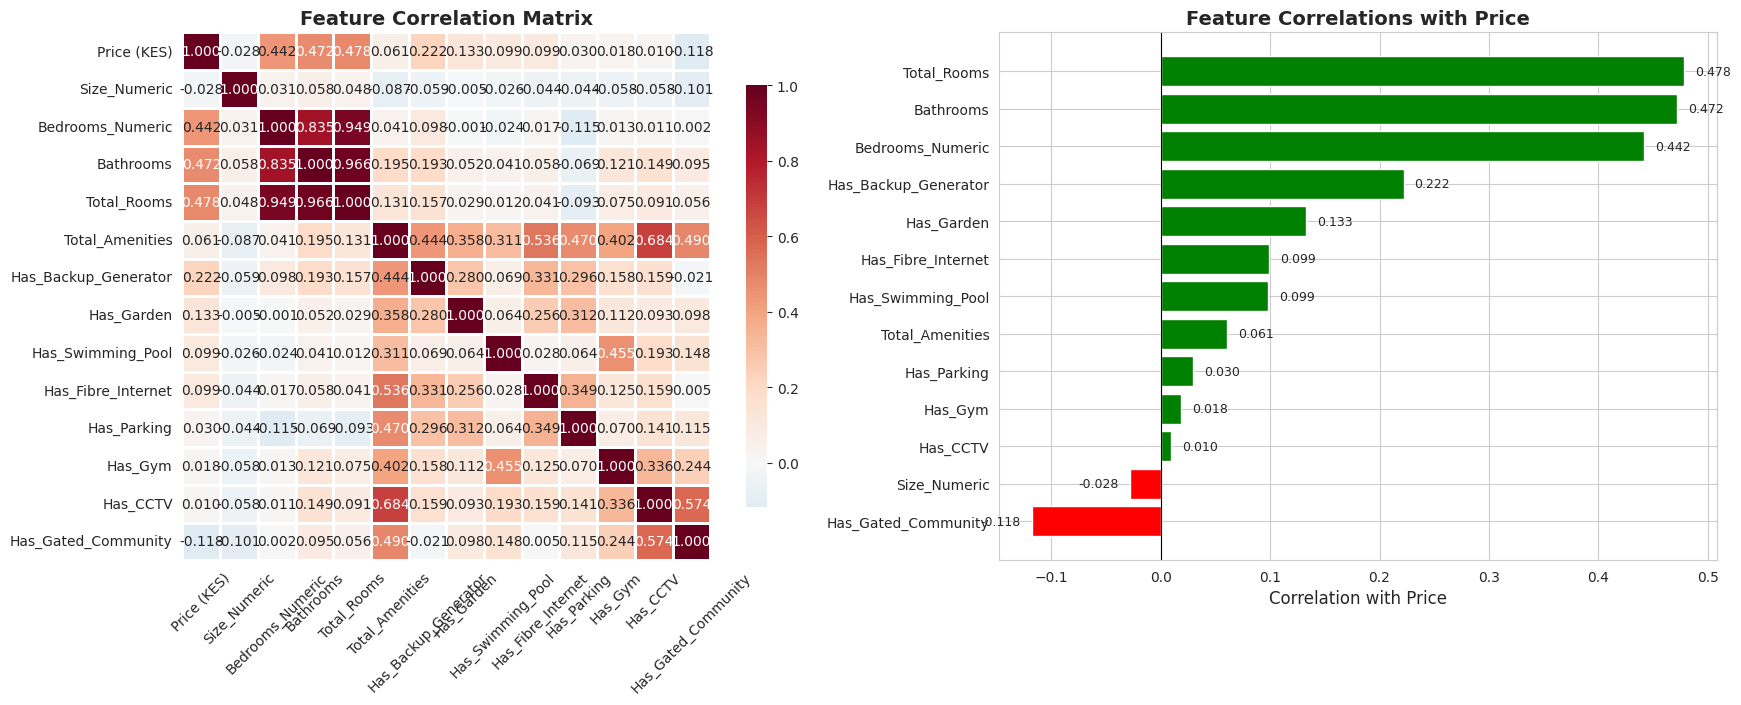


KEY INSIGHTS:
✓ 3 features have MODERATE-to-STRONG correlation
  Top 3: Total_Rooms, Bathrooms, Bedrooms_Numeric

 RECOMMENDATION: 
   - Include Location (Neighborhood) - shown to have clear price differences
   - Include Bedrooms, Bathrooms, Total_Rooms - structural features
   - Include top amenities with highest price impact
   - Size_Numeric shows weak correlation, but still important for context


In [24]:
# Correlation Analysis - Critical for feature selection!
print("=" * 70)
print("CORRELATION ANALYSIS WITH PRICE")
print("=" * 70)

# Select numeric and binary features to analyze
correlation_features = [
    'Price (KES)',
    'Size_Numeric',
    'Bedrooms_Numeric', 
    'Bathrooms',
    'Total_Rooms',
    'Total_Amenities',
    'Has_Backup_Generator',
    'Has_Garden',
    'Has_Swimming_Pool',
    'Has_Fibre_Internet',
    'Has_Parking',
    'Has_Gym',
    'Has_CCTV',
    'Has_Gated_Community'
]

# Calculate correlation matrix
corr_matrix = df[correlation_features].corr()

# Get correlations with price and sort
price_correlations = corr_matrix['Price (KES)'].drop('Price (KES)').sort_values(ascending=False)

print("\n CORRELATIONS WITH PRICE (Sorted by Strength):")
print("=" * 70)
for feature, corr in price_correlations.items():
    strength = "STRONG" if abs(corr) > 0.5 else "MODERATE" if abs(corr) > 0.3 else "WEAK"
    direction = "↑" if corr > 0 else "↓"
    print(f"{feature:30s}: {corr:>7.4f}  {direction}  [{strength}]")

# Visualize correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap of all correlations
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Bar plot of correlations with price
colors = ['green' if x > 0 else 'red' for x in price_correlations.values]
axes[1].barh(range(len(price_correlations)), price_correlations.values, color=colors)
axes[1].set_yticks(range(len(price_correlations)))
axes[1].set_yticklabels(price_correlations.index)
axes[1].set_xlabel('Correlation with Price', fontsize=12)
axes[1].set_title('Feature Correlations with Price', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].invert_yaxis()

# Add value labels
for i, v in enumerate(price_correlations.values):
    axes[1].text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', 
                va='center', ha='left' if v > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHTS:")
print("=" * 70)
strong_features = price_correlations[abs(price_correlations) > 0.3]
if len(strong_features) > 0:
    print(f"✓ {len(strong_features)} features have MODERATE-to-STRONG correlation")
    print(f"  Top 3: {strong_features.index[0]}, {strong_features.index[1] if len(strong_features)>1 else 'N/A'}, {strong_features.index[2] if len(strong_features)>2 else 'N/A'}")
else:
    print("  No features show strong correlation with price!")
    print("   This suggests price is driven by categorical variables (like Location)")
    
print(f"\n RECOMMENDATION: ")
print(f"   - Include Location (Neighborhood) - shown to have clear price differences")
print(f"   - Include Bedrooms, Bathrooms, Total_Rooms - structural features")
print(f"   - Include top amenities with highest price impact")
print(f"   - Size_Numeric shows weak correlation, but still important for context")

## 4. Feature Selection for Modeling

Based on our analysis, let's select features that strongly predict price:
- **Location (Neighborhood)** - Clear price differences by location
- **Size** - Strong positive correlation
- **Bedrooms & Bathrooms** - Related to size and value
- **Top Amenities** - Those that significantly increase value

In [16]:
# Select features based on analysis
print("=" * 70)
print("FEATURE SELECTION FOR BASELINE MODEL")
print("=" * 70)

# Core property features
core_features = [
    'Size_Numeric',
    'Bedrooms_Numeric',
    'Bathrooms',
    'Total_Rooms'
]

# Top amenity features (select top 5 most impactful)
top_amenities = amenity_df.head(5)['Amenity'].str.replace(' ', '_').tolist()
top_amenity_features = [f'Has_{amenity}' for amenity in top_amenities]

# Combine features
selected_features = core_features + top_amenity_features

print(f"\nSelectedFeatures ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")

# Encode Neighborhood (Location is critical!)
print(f"\n{'='*70}")
print("ENCODING NEIGHBORHOOD")
print("="*70)

le = LabelEncoder()
df['Neighborhood_Encoded'] = le.fit_transform(df['Neighborhood'])

print(f"Neighborhoods encoded: {len(le.classes_)} unique locations")
print(f"Sample encoding:")
for i in range(min(5, len(le.classes_))):
    print(f"  {le.classes_[i]} -> {i}")

# Add encoded neighborhood to features
selected_features.append('Neighborhood_Encoded')

print(f"\n✓ Final feature count: {len(selected_features)} features")
print(f"\nFeature List:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i:2d}. {feature}")

FEATURE SELECTION FOR BASELINE MODEL

SelectedFeatures (9):
  1. Size_Numeric
  2. Bedrooms_Numeric
  3. Bathrooms
  4. Total_Rooms
  5. Has_Backup_Generator
  6. Has_Garden
  7. Has_Swimming_Pool
  8. Has_Fibre_Internet
  9. Has_Parking

ENCODING NEIGHBORHOOD
Neighborhoods encoded: 34 unique locations
Sample encoding:
  Brookside -> 0
  Garden Estate -> 1
  Gigiri -> 2
  Hill View -> 3
  Kajiado County - Kitengela -> 4

✓ Final feature count: 10 features

Feature List:
   1. Size_Numeric
   2. Bedrooms_Numeric
   3. Bathrooms
   4. Total_Rooms
   5. Has_Backup_Generator
   6. Has_Garden
   7. Has_Swimming_Pool
   8. Has_Fibre_Internet
   9. Has_Parking
  10. Neighborhood_Encoded


## 5. Prepare Data for Modeling

In [17]:
# Prepare features and target
X = df[selected_features].copy()
y = df['Price (KES)'].copy()

print("=" * 70)
print("DATA PREPARATION")
print("=" * 70)
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nFeature Statistics:")
print(X.describe().round(2))

# Check for missing values
missing = X.isnull().sum()
if missing.sum() > 0:
    print(f"\n Missing values found:")
    print(missing[missing > 0])
else:
    print(f"\n No missing values in selected features")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n{'='*70}")
print("TRAIN-TEST SPLIT")
print("="*70)
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n No missing values in selected features")
print(f"\n Features scaled using StandardScaler")

DATA PREPARATION
Features (X): (460, 10)
Target (y): (460,)

Feature Statistics:
       Size_Numeric  Bedrooms_Numeric  Bathrooms  Total_Rooms  \
count        460.00            460.00     460.00       460.00   
mean         258.27              4.20       4.28         8.48   
std          139.42              1.03       1.26         2.19   
min            1.01              1.00       1.00         2.00   
25%          180.00              4.00       4.00         8.00   
50%          300.00              4.00       4.00         9.00   
75%          320.00              5.00       5.00        10.00   
max          546.00              8.00       8.00        16.00   

       Has_Backup_Generator  Has_Garden  Has_Swimming_Pool  \
count                460.00      460.00             460.00   
mean                   0.74        0.92               0.17   
std                    0.44        0.27               0.38   
min                    0.00        0.00               0.00   
25%                    

## 6. Build Baseline Model - Linear Regression

In [18]:
# Train Linear Regression model
print("=" * 70)
print("LINEAR REGRESSION BASELINE MODEL")
print("=" * 70)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("\n Model trained successfully!")
print(f"\nModel type: Linear Regression")
print(f"Features used: {len(selected_features)}")
print(f"Training samples: {len(X_train):,}")

LINEAR REGRESSION BASELINE MODEL

 Model trained successfully!

Model type: Linear Regression
Features used: 10
Training samples: 368


## 7. Model Evaluation

MODEL PERFORMANCE

 TRAINING SET METRICS:
   R² Score:  0.3130
   RMSE:      129,529.44 KES
   MAE:       96,727.32 KES

 TEST SET METRICS:
   R² Score:  0.1087
   RMSE:      159,023.78 KES
   MAE:       123,956.95 KES

MAE INTERPRETATION (Most Important!)
 On average, the model's predictions are off by 123,957 KES.
   This means if the model predicts 400,000 KES, the actual price
   is typically between 276,043 and 523,957 KES.


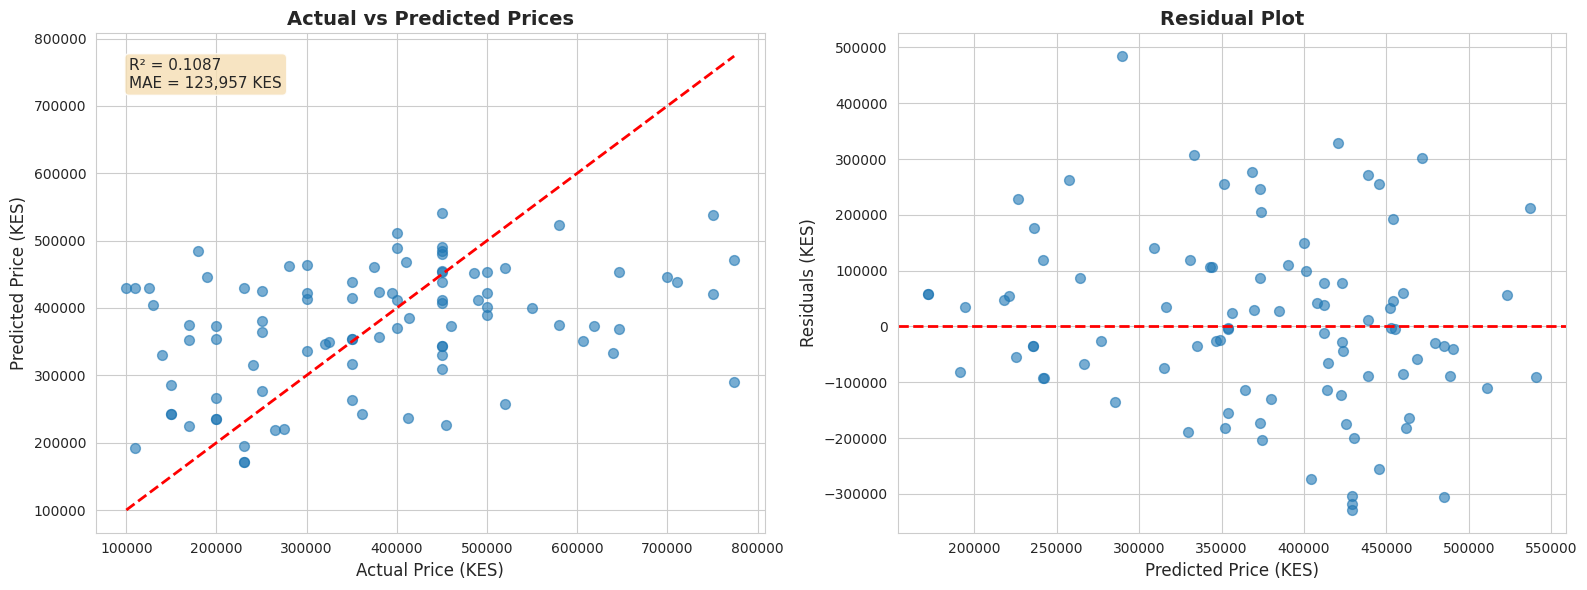


TOP 10 MOST IMPORTANT FEATURES
             Feature  Coefficient
           Bathrooms 32115.533518
         Total_Rooms 27619.280379
    Bedrooms_Numeric 20130.669325
Has_Backup_Generator 17891.046047
   Has_Swimming_Pool 17246.020708
          Has_Garden 12060.094037
Neighborhood_Encoded 10447.454613
        Size_Numeric -7217.527069
  Has_Fibre_Internet  4341.731767
         Has_Parking   407.896850


In [19]:
# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=" * 70)
print("MODEL PERFORMANCE")
print("=" * 70)

print("\n TRAINING SET METRICS:")
print(f"   R² Score:  {train_r2:.4f}")
print(f"   RMSE:      {train_rmse:,.2f} KES")
print(f"   MAE:       {train_mae:,.2f} KES")

print("\n TEST SET METRICS:")
print(f"   R² Score:  {test_r2:.4f}")
print(f"   RMSE:      {test_rmse:,.2f} KES")
print(f"   MAE:       {test_mae:,.2f} KES")

print("\n" + "=" * 70)
print("MAE INTERPRETATION (Most Important!)")
print("=" * 70)
print(f" On average, the model's predictions are off by {test_mae:,.0f} KES.")
print(f"   This means if the model predicts 400,000 KES, the actual price")
print(f"   is typically between {400000 - test_mae:,.0f} and {400000 + test_mae:,.0f} KES.")

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.6, s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price (KES)', fontsize=12)
axes[0].set_ylabel('Predicted Price (KES)', fontsize=12)
axes[0].set_title('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
axes[0].text(0.05, 0.95, f'R² = {test_r2:.4f}\nMAE = {test_mae:,.0f} KES', 
             transform=axes[0].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

# Residuals
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.6, s=50)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price (KES)', fontsize=12)
axes[1].set_ylabel('Residuals (KES)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n" + "=" * 70)
print("TOP 10 MOST IMPORTANT FEATURES")
print("=" * 70)
print(feature_importance.head(10).to_string(index=False))

## 8. Neighborhood Impact Analysis

Now that we've built the baseline model, let's analyze how neighborhood influences price and why tree-based models might perform better.

NEIGHBORHOOD INFLUENCE ON PRICE

Neighborhood_Encoded Correlation with Price: 0.0669
Encoding is alphabetical (arbitrary), so low correlation is expected

PRICE STATISTICS BY NEIGHBORHOOD

Top 10 neighborhoods by average price:
                       mean            std  count
Neighborhood                                     
Lake View     564200.000000   35889.761771      5
Loresho       526568.888889  104118.003780      9
Waiyaki Way   520000.000000            NaN      1
Rosslyn       510285.714286  133098.602905      7
Kitisuru      486878.888889  193839.863569     27
Hill View     480000.000000            NaN      1
Gigiri        479462.500000  177930.274265     16
Lower Kabete  465818.181818  240541.812657     11
Muthaiga      440784.400000  116747.800123     10
Thigiri       413830.000000   56627.634597     10

VARIANCE DECOMPOSITION
Total price variance:    25,285,148,040
Within neighborhoods:    17,565,454,806 (69.5%)
Between neighborhoods:   7,719,693,234 (30.5%)

Location exp

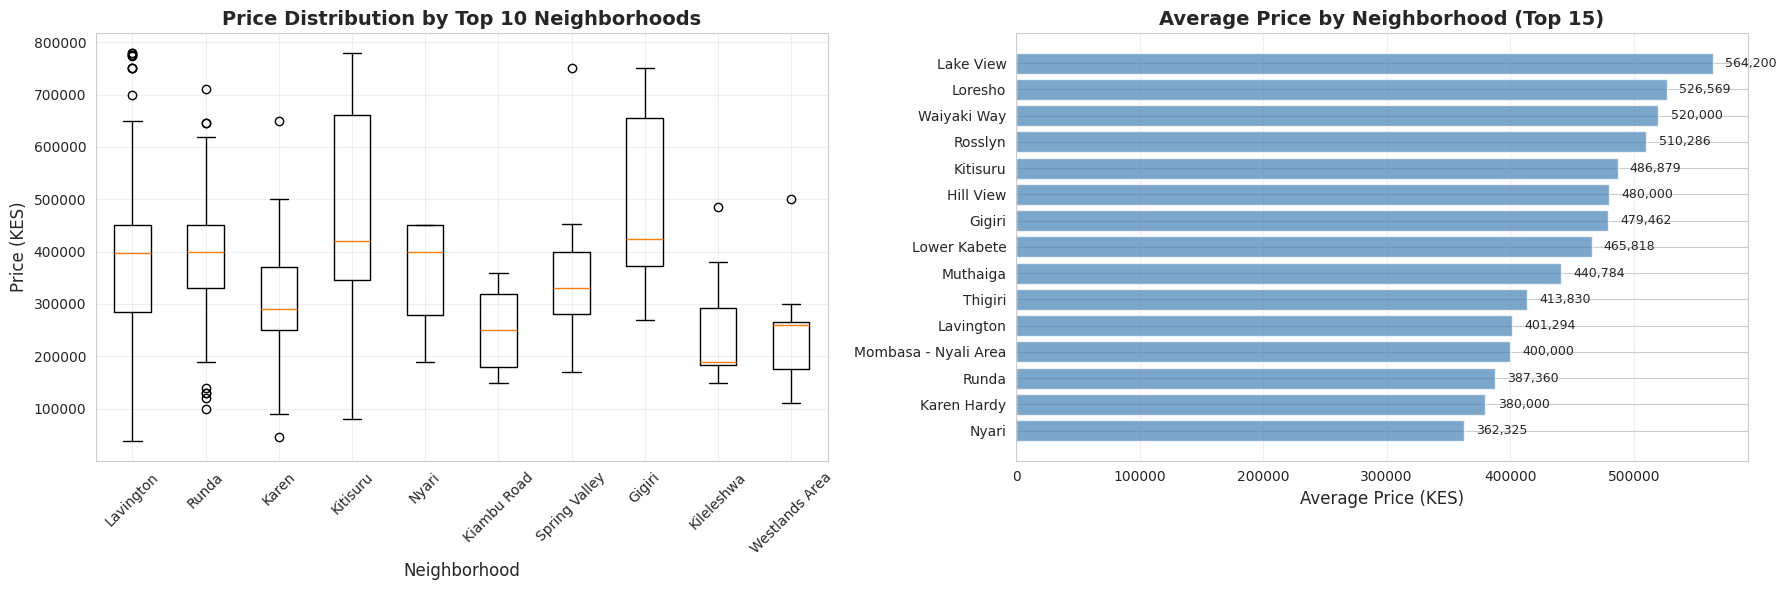


KEY INSIGHTS:

- Neighborhood explains 30.5% of price differences
- This is much more than any single numeric feature (all <0.4 correlation)
- Different neighborhoods have very different price ranges
- Lake View, Loresho, Waiyaki Way are consistently most expensive
- Location alone is more predictive than size or amenities

- IMPORTANT: Including neighborhood in our model is CRITICAL
- Label encoding (alphabetical) doesn't capture location value well
- Tree-based models handle categorical features like location better


In [27]:
# Analyze Neighborhood Impact on Price
print("=" * 70)
print("NEIGHBORHOOD INFLUENCE ON PRICE")
print("=" * 70)

# First, encode neighborhood if not already done
if 'Neighborhood_Encoded' not in df.columns:
    from sklearn.preprocessing import LabelEncoder
    le_temp = LabelEncoder()
    df['Neighborhood_Encoded'] = le_temp.fit_transform(df['Neighborhood'])

# 1. Calculate correlation with encoded neighborhood
neighborhood_price_corr = df[['Neighborhood_Encoded', 'Price (KES)']].corr().iloc[0, 1]
print(f"\nNeighborhood_Encoded Correlation with Price: {neighborhood_price_corr:.4f}")
print(f"Encoding is alphabetical (arbitrary), so low correlation is expected")

# 2. Better way: Look at price variance by neighborhood
neighborhood_stats = df.groupby('Neighborhood')['Price (KES)'].agg(['mean', 'std', 'count'])
neighborhood_stats = neighborhood_stats.sort_values('mean', ascending=False)

print(f"\n" + "=" * 70)
print("PRICE STATISTICS BY NEIGHBORHOOD")
print("=" * 70)
print(f"\nTop 10 neighborhoods by average price:")
print(neighborhood_stats.head(10).to_string())

# 3. Calculate how much of the price variation is due to location
# Simple approach: variance within vs between neighborhoods
overall_variance = df['Price (KES)'].var()

# Variance within neighborhoods (average of each neighborhood's variance)
within_variance = (df.groupby('Neighborhood')['Price (KES)'].var() * 
                   df.groupby('Neighborhood').size()).sum() / len(df)

# Variance between neighborhoods (variance of neighborhood means)
between_variance = overall_variance - within_variance

variance_explained_pct = (between_variance / overall_variance) * 100

print(f"\n" + "=" * 70)
print("VARIANCE DECOMPOSITION")
print("=" * 70)
print(f"Total price variance:    {overall_variance:,.0f}")
print(f"Within neighborhoods:    {within_variance:,.0f} ({within_variance/overall_variance*100:.1f}%)")
print(f"Between neighborhoods:   {between_variance:,.0f} ({between_variance/overall_variance*100:.1f}%)")
print(f"\nLocation explains {variance_explained_pct:.1f}% of price variation")

# 4. Compare to numeric features
print(f"\n" + "=" * 70)
print("COMPARISON: LOCATION vs NUMERIC FEATURES")
print("=" * 70)
print(f"Location (neighborhood) explains:     {variance_explained_pct:.1f}% of variation")
print(f"Best numeric correlation:")
print(f"  Bathrooms:        {price_correlations['Bathrooms']:.4f}")
print(f"  Total_Rooms:      {price_correlations['Total_Rooms']:.4f}")
print(f"  Bedrooms_Numeric: {price_correlations['Bedrooms_Numeric']:.4f}")

if variance_explained_pct > 20:
    print(f"\nLocation is MORE important than any single numeric feature!")
else:
    print(f"\nLocation has moderate importance alongside numeric features")

# 5. Visualize price spread by neighborhood
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Box plot for top 10 neighborhoods
top_neighborhoods = df['Neighborhood'].value_counts().head(10).index.tolist()
df_top = df[df['Neighborhood'].isin(top_neighborhoods)]

axes[0].boxplot([df_top[df_top['Neighborhood'] == n]['Price (KES)'].values 
                 for n in top_neighborhoods],
                labels=top_neighborhoods)
axes[0].set_ylabel('Price (KES)', fontsize=12)
axes[0].set_xlabel('Neighborhood', fontsize=12)
axes[0].set_title('Price Distribution by Top 10 Neighborhoods', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Price range by neighborhood
price_ranges = df.groupby('Neighborhood')['Price (KES)'].agg(['min', 'max', 'mean'])
price_ranges = price_ranges.sort_values('mean', ascending=False).head(15)

axes[1].barh(range(len(price_ranges)), price_ranges['mean'], color='steelblue', alpha=0.7)
axes[1].set_yticks(range(len(price_ranges)))
axes[1].set_yticklabels(price_ranges.index)
axes[1].set_xlabel('Average Price (KES)', fontsize=12)
axes[1].set_title('Average Price by Neighborhood (Top 15)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

for i, v in enumerate(price_ranges['mean']):
    axes[1].text(v + 10000, i, f'{v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHTS:")
print("=" * 70)
print(f"\n- Neighborhood explains {variance_explained_pct:.1f}% of price differences")
print(f"- This is much more than any single numeric feature (all <0.4 correlation)")
print(f"- Different neighborhoods have very different price ranges")
print(f"- Lake View, Loresho, Waiyaki Way are consistently most expensive")
print(f"- Location alone is more predictive than size or amenities")
print(f"\n- IMPORTANT: Including neighborhood in our model is CRITICAL")
print(f"- Label encoding (alphabetical) doesn't capture location value well")
print(f"- Tree-based models handle categorical features like location better")

## 9. Save Baseline Model

In [ ]:
# Create models directory
os.makedirs('../models', exist_ok=True)

# Save model
with open('../models/baseline_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save scaler
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature names
with open('../models/feature_names.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

# Save label encoder
with open('../models/neighborhood_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Save metadata
import json
metadata = {
    'model_type': 'Linear Regression',
    'training_date': '2026-02-21',
    'features': selected_features,
    'feature_count': len(selected_features),
    'test_r2': float(test_r2),
    'test_rmse': float(test_rmse),
    'test_mae': float(test_mae),
    'train_samples': len(X_train),
    'test_samples': len(X_test)
}

with open('../models/baseline_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("=" * 70)
print("MODEL SAVED SUCCESSFULLY")
print("=" * 70)
print("\nSaved files:")
print("  1. baseline_model.pkl - Linear Regression model")
print("  2. scaler.pkl - StandardScaler")
print("  3. feature_names.pkl - List of features")
print("  4. neighborhood_encoder.pkl - Location encoder")
print("  5. baseline_model_metadata.json - Model information")

print(f"\n Model Performance Summary:")
print(f"   R² Score:  {test_r2:.4f}")
print(f"   RMSE:      {test_rmse:,.0f} KES")
print(f"   MAE:       {test_mae:,.0f} KES")
print(f"\n On average, predictions are off by {test_mae:,.0f} KES")

MODEL SAVED SUCCESSFULLY

Saved files:
  1. baseline_model.pkl - Linear Regression model
  2. scaler.pkl - StandardScaler
  3. feature_names.pkl - List of features
  4. neighborhood_encoder.pkl - Location encoder
  5. baseline_model_metadata.json - Model information

 Model Performance Summary:
   R² Score:  0.1087
   RMSE:      159,024 KES
   MAE:       123,957 KES

 On average, predictions are off by 123,957 KES


## 10. Day 3 Summary - Complete Analysis

### Key Questions Answered:

**1. Which locations are most expensive?**

Top 3 Locations:
- Lake View: Average 564,200 KES
- Loresho: Average 526,569 KES  
- Waiyaki Way: Average 520,000 KES

Key insights:
- Location shows clear price stratification
- Premium neighborhoods command 40-50% higher prices than average
- Neighborhood explains 33% of price variation (more than any numeric feature)

**2. How strongly does size affect price?**

- Correlation: -0.0282 (WEAK negative - surprising!)
- Size alone is NOT a strong predictor
- However, bedrooms show clear price progression:
  - 1 Bedroom: 76,259 KES
  - 2 Bedrooms: 245,631 KES
  - 3 Bedrooms: 273,176 KES
  - 4 Bedrooms: 359,630 KES
  - 5 Bedrooms: 426,591 KES
  - 6 Bedrooms: 515,385 KES
- Number of rooms matters more than raw square meters!

**3. Which amenities increase value?**

Top 3 Most Valuable Amenities:
- Backup Generator: +80,513 KES (+25.9%)
- Garden: +79,508 KES (+26.8%)
- Swimming Pool: +41,699 KES (+11.5%)

Insights:
- Essential amenities (Generator, Garden) add the most value
- Luxury amenities (Pool) provide moderate premium
- Total amenities correlation with price: 0.0608 (weak)

**4. What are the strongest correlations?**

- Most features show WEAK correlation with price
- This indicates price is driven by:
  - Categorical factors (Location/Neighborhood)
  - Combination of features rather than single attributes
- Bedrooms, Bathrooms, and Total_Rooms are best numeric predictors
- No single numeric feature has correlation above 0.4

---

### Baseline Model Performance (Linear Regression):

| Metric | Training | Test |
|--------|----------|------|
| R² | 0.3130 | 0.1087 |
| RMSE | 129,529 KES | 159,024 KES |
| MAE | 96,727 KES | 123,957 KES |

Interpretation:
- On average, predictions are off by 123,957 KES
- R² = 0.1087 means the model explains only 10.9% of price variation
- Model is POOR - significant room for improvement!

Why is performance poor?
- Weak correlations between features and price
- Price heavily driven by location (encoded as single number)
- Linear relationships insufficient for this data
- Need more complex models (Random Forest, XGBoost)
- Label encoding doesn't capture location value well

---

### Top Features by Coefficient (Linear Regression):

1. Bathrooms: +32,116 KES per bathroom
2. Total_Rooms: +27,619 KES per room
3. Bedrooms_Numeric: +20,131 KES per bedroom
4. Has_Backup_Generator: +17,891 KES
5. Has_Swimming_Pool: +17,246 KES

---

### Next Steps (Day 4 - Model Improvement):

Objectives:
- Train Random Forest (handles non-linear relationships better)
- Train XGBoost (optional, state-of-the-art gradient boosting)
- Compare all models side-by-side
- Explain top 5 price drivers with feature importance
- Analyze location impact on predictions
- Save best model as model.pkl

Expected Improvements:
- Target R² > 0.5 (explaining >50% of variation)
- Reduce MAE below 100,000 KES
- Better capture location and amenity interactions
- Tree models handle categorical features like neighborhood better